In [1]:
from folktables import ACSDataSource, ACSEmployment, employment_filter, BasicProblem
import tensorflow as tf
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import os
import math
import pickle
from random import randint
import matplotlib.pyplot as plt

2024-06-26 10:11:28.267314: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-26 10:11:29.485828: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
from student import *
from aggregator import *
from teacher_ensemble import *
(x_train, x_test, y_train, y_test, s_train, s_test) = load_student_data("AK", attr="sex")

KeyboardInterrupt: 

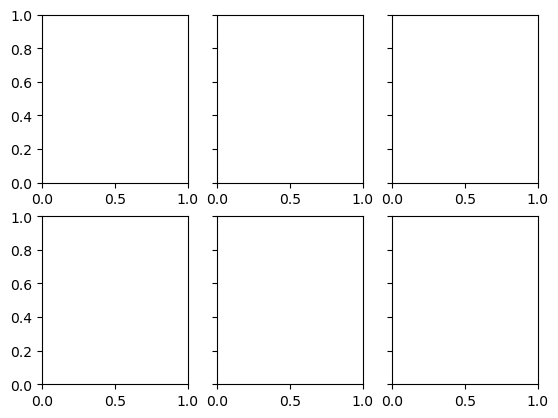

In [10]:
from multiprocessing import Pool

def training_student(nb_teachers, nb_fair_tchrs, beta=100):
    loc_st_fairness = {"Normal": [], "ff": []}
    
    tchrs_ensemble = Ensemble(nb_teachers, nb_fair_tchrs)
    update_teachers(tchrs_ensemble.tchrs)

    metric = []
    metric_key = "SPD"
    for tchrs in tchrs_ensemble.tchrs:
        metric.append(tchrs.metrics[metric_key])
    set_metrics(metric)

    # with fairfed
    y_train, _ = fair_fed_agg(x_train, beta=beta)
    yhat_test, _ = fair_fed_agg(x_test, beta=beta)
    st_model = train_student(x_train, y_train, verbose=False)
    loc_st_fairness["ff"].append(fairness(st_model, x_test, yhat_test, s_test, y_test))
    
    # Normal
    y_train, _ = plurality(x_train)
    yhat_test, _ = plurality(x_test)
    st_model = train_student(x_train, y_train, verbose=False)
    loc_st_fairness["Normal"].append(fairness(st_model, x_test, yhat_test, s_test, y_test))
    
    return loc_st_fairness

def wrapper(args):
    return training_student(*args)

def get_fairfed_beta_impact():
    fig, ((ax1,ax2,ax3), (ax4,ax5,ax6)) = plt.subplots(2,3, sharey=True)
    nb_teachers = 30
    axes = [ax1, ax2, ax3, ax4, ax5, ax6]
    axe_ind = 0
    for beta in [10, 20, 30, 40, 50, 100]:
        st_fairness = {"Normal": [], "ff": []}
        loc_st_fairnesses = []
        with Pool(5) as p:
            loc_st_fairnesses = p.map(wrapper, [(nb_teachers, i, beta) for i in range(1, nb_teachers)])
            p.close()
        print("Not here too !")
        for cf in ["Normal", "ff"]:
            st_fairness[cf] = sum([l_st_f[cf] for l_st_f in loc_st_fairnesses], [])
        
        for nb_fair in range(1, nb_teachers):
            f = training_student(nb_teachers, nb_fair, beta)
            stats_ff.append(f[0])
            stats.append(f[1])
        axes[axe_ind].plot(list(range(1, nb_teachers)), st_fairness["Normal"], color=colors[0], label="Normal")
        axes[axe_ind].plot(list(range(1, nb_teachers)), st_fairness["ff"], color=colors[1], label=f"beta: {beta}")
        axes[axe_ind].legend()
        axe_ind += 1
        print(">> beta.... ", beta, "...Done")
        
get_fairfed_beta_impact()

In [ ]:
plt.show()